In [1]:
import numpy as np
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from Landscapes import *
import pandas as pd


In [91]:
def Get_Landscape_Statistics_Outputs(df,N,K,mycolor="b"):


    ##Record the autocorrelation of a random walk
    #FitnessPath = random_walker(1000, df)
    #AR = Get_AR(FitnessPath,lag_range=N)


    ##Now find the maximum and minimum.
    MaximalLocation = df.iloc[:,0].idxmax()    #get the index
    MaximalFitness = df.iloc[:,0].max() #get the fitness value
    #MaximalFitness2 = df[MaximalLocation,0]
    #,MaximalFitness2)
    MinimalLocation = df.iloc[:,0].idxmin()
    MinimalFitness = df.iloc[:,0].min()

    #Get normalized difference between min and max (by dividing by standard deviation)
    #NormDiff = (MaximalFitness-MinimalFitness)/(df.iloc[:,0].var()**0.5)
#
    ##get distance between min and max
    #Changes = sum(abs(np.array(df.loc[MinimalLocation].Location)-np.array(df.loc[MaximalLocation].Location)))
#
    #####Now generate a statistic that finds how close on average, are the 90th percentile and above
    #####fitness to the maximum
    #Percentile_90_Cutoff = (df.iloc[:,0].quantile(.90))
    ##get those that pass cutoff
    #CutoffPassed = df[ df.iloc[:,0]>= Percentile_90_Cutoff ]
    #Distances = CutoffPassed['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    #Average_Distance_Percentile_90=Distances.mean()
#
    ###Now Identify the Number of Maxima and distancw to global
    #
    Current_Maximas_Model = Local_Maxima_Locations(df)
    Current_Maximas_Model = Current_Maximas_Model[Current_Maximas_Model['Maxima']==1]
    Number_Maxima = sum(Current_Maximas_Model['Maxima'])
    Distances_Maximas_to_Global = Current_Maximas_Model['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    Average_Distances_Maximas_to_Global=Distances_Maximas_to_Global.mean()
    Var_Distances_Maximas_to_Global=Distances_Maximas_to_Global.var()
    Max_Distances_Maximas_to_Global=Distances_Maximas_to_Global.max()

        
    return(Number_Maxima,
           Average_Distances_Maximas_to_Global,Var_Distances_Maximas_to_Global,Max_Distances_Maximas_to_Global)

    plt.figure(figsize=(10,4))
    plt.title("Auto-correlation by step distance, N={} K={}".format(N,K),size=24)
    plt.grid()
    plt.plot(AR,color=mycolor)
    plt.show()
    print("Max Fitness\t\t\t\t", MaximalFitness)
    print("Min Fitness\t\t\t\t", MinimalFitness)
    print("Normed difference in fitness\t\t", NormDiff)
    print("Distance btw min and max\t\t", Changes)
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    

In [120]:

def Count_Local_Maxima_Distances(df):
    #Set A Maxima counter
    Num_Local_Max=0
    #Loop over all rows
    Distances =[]
    MaximalLocation = df.iloc[:,0].idxmax() 
    for focal_row in df.itertuples():
        #Identify the Neighbors (distance of 1 from focal row)
        Neighbors = df[df['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(focal_row.Location)))==1)]        #Get the maximum fitness value of the neighbors
        Neighbors_Max = max(Neighbors.Fitness) #fitness is indexed at 0 here for some reason

        ##See if the neighbors max does not exceed the focal max, if not then it is a local maxima
        if Neighbors_Max < focal_row.Fitness: #fitness is indexed at 1 here for some reason
            #print('Local Maxima found')
            Num_Local_Max += 1
            #print(np.array(focal_row))
            #print(np.array(df.loc[MaximalLocation].Location))
            Dist = sum(abs(np.array(focal_row.Location)-np.array(df.loc[MaximalLocation].Location)))
            #don't include global maxima
            if Dist !=0:
            #Dist = np.array(focal_row)-np.array(df.loc[MaximalLocation].Location)
                Distances.append(Dist)
                
        #Append the focal row at the end
    Distances=np.array(Distances)

    return(Num_Local_Max,Distances.mean(),Distances.var(),Distances.max())


In [121]:
Count_Local_Maxima_Distances(current_land)

(35, 4.5, 1.5441176470588236, 7)

In [92]:
def create_dotSpace(N=10,hypers=[1,1,1,1,1,1,1,1,1,1],masked=False, mask=None):
    our_dirichlet = stats.dirichlet(hypers)    
    all_permutations = list(itertools.product([0,1],repeat = N))
    fitnesses = []
    perms = []
    transformed_locs = []
    for perm in all_permutations:
        fitnesses.append(np.dot(perm,our_dirichlet.rvs()[0]))
        if masked:
            if mask:
                perm = transform(perm,mask)
            else:
                perm = transform(perm)
        perms.append("".join([str(i) for i in perm]))
        transformed_locs.append(perm)
    frame = {"Fitness":pd.Series(fitnesses,index=perms), "Location":pd.Series(transformed_locs,index=perms)}
    return pd.DataFrame(frame)

def transform(location, mask=[1,0,1,0,0,0,1,1,1,0]):
    assert len(location) == len(mask), "The mask needs to be same length as the location"
    
    return [abs(i-1) if j==1 else i for i,j in zip(location, mask)]

def get_iterated_search_walk(Landscape,Neighbor_Distance,Step_Size,Iterations):
    #initalize random position
    N=len(Landscape.iloc[0].Location)
    Position= Position_rand(N)

    FitnessHistory=[Landscape.loc["".join([str(i) for i in Position])].Fitness]
    #record jumps down
    Jump_Down_history=[1]

    for j in range(Iterations):

        #Identify the Neighbors (distance of M from initial position row)
        Neighbors = Landscape[Landscape['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(Landscape.loc["".join([str(i) for i in Position])].Location)))==Neighbor_Distance)]

        BetterNeighbors = Neighbors[Neighbors.Fitness>Landscape.loc["".join([str(i) for i in Position])].Fitness]
        #randomize order of neighobrs then loop until one exceeds
        if len(BetterNeighbors)>0: #only update if there exists at least one superior neighobr
            BetterNeighbors.sample(frac=1)#randomly sample better neighbors
            Position = BetterNeighbors.index.values[0] #return the first index value
            Jump_Down_history.append(0)

        #take a step of size Step_Size
        else:
            Position = Perturbation(Position,Step_Size)
            Jump_Down_history.append(1)

            #Append to fitness data
        fit = Landscape.loc["".join([str(i) for i in Position])].Fitness
        FitnessHistory.append(fit)
        
    return(FitnessHistory,Jump_Down_history)


    
def Get_Landscape_Summary(df,N):


    ##Record the autocorrelation of a random walk
    FitnessPath = random_walker(1000, df)
    AR = Get_AR(FitnessPath,lag_range=N)

    MaximalLocation = df.iloc[:,0].idxmax() #get the index

    ####Now generate a statistic that finds how close on average, are the 90th percentile and above
    ####fitness to the maximum
    Percentile_90_Cutoff = (df.iloc[:,0].quantile(.90))
    #get those that pass cutoff
    CutoffPassed = df[ df.iloc[:,0]>= Percentile_90_Cutoff]
    Distances = CutoffPassed['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    Average_Distance_Percentile_90=Distances.mean()

    ##Now Identify the Number of Maxima
    Number_Maxima = Count_Local_Maxima(df)

    history, jump_history = get_iterated_search_walk(df,1,2,150)
    
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    print("Mean fitness",df.Fitness.mean())
    print("S.D. of fitness", df.Fitness.var()**.5)

    f, axarr = plt.subplots(2,2,figsize=(15,10))
    axarr[0,0].set_title("Auto-correlation by step distance",size=14)
    axarr[0,0].plot(AR,color="b")
    axarr[0,1].set_title("Random Walk",size=14)
    axarr[0,1].plot(FitnessPath[:250])
    axarr[1,0].set_title("Iterated Local Search", size=14)
    axarr[1,0].plot((history),'r--o',label='k=1')
    axarr[1,0].plot((jump_history),'*',label='k=1_Jump')
    axarr[1,0].legend()

    axarr[1,1].set_title("Fitness Distribution", size=14)
    axarr[1,1].hist(df["Fitness"])
    
    plt.show()
    
    cmap=plt.cm.get_cmap('coolwarm')
    landscape_as_graph(df,cmap)

    
def landscape_as_graph(df,cmap):

    N=len(df.iloc[0].name)
    hypercube = nx.hypercube_graph(N)

    colors=[]
    fitness_dict = {}
    f_min = df.iloc[:,0].min()
    f_max = df.iloc[:,0].max()
    fractor = 1/(f_max-f_min)
    for row, focal_row in df.iterrows():
        source_fit = fractor*(focal_row.Fitness - f_min)
        fitness_dict[row]= source_fit
        colors.append(cmap(source_fit))

    nx.set_node_attributes(hypercube,fitness_dict, "fitness")

    nx.draw(hypercube, node_color=colors, with_labels=False, node_size=50,width=.25)  



    

In [2]:
My_Land = make_NK_land(10, 1)


In [4]:
AAA = Local_Maxima_Locations(My_Land)

In [6]:
sum(AAA['Maxima'])

0000000000    0
0000000001    0
0000000010    0
0000000011    0
0000000100    0
             ..
1111111011    0
1111111100    0
1111111101    0
1111111110    0
1111111111    0
Name: Maxima, Length: 1024, dtype: int64

In [ ]:
N=10
for K in range(10):
    current_land = make_NK_land(N, K)
    Current_Maximas_Model = Local_Maxima_Locations(My_Land)
    Num_Maxima = sum(Current_Maximas_Model['Maxima'])


In [ ]:
N=10
Landscape_stats_Kauffman=[]
for K in range(1,10):
    print(K)
    for i in range(10):
        print(i)
        current_land = make_NK_land(N, K)
        Current_Stats = Get_Landscape_Statistics_Outputs(current_land,N,K)
        Landscape_stats_Kauffman.append(Current_Stats)
      #  Get_Landscape_Statistics(landscape,N,K)


In [105]:
Count_Local_Maxima_Distances(current_land)

['0000011110' 0.5189095717267815 (0, 0, 0, 0, 0, 1, 1, 1, 1, 0) 1]
[1 1 1 1 1 1 1 1 1 1]


ValueError: operands could not be broadcast together with shapes (4,) (10,) 

In [95]:
N=10
Landscape_stats_dot=[]
for K in range(1,3):
    for i in range(2):
        print(i)
        Hypers =[K,K,K,K,K,K,K,K,K,K]
        current_land = create_dotSpace(N,Hypers)
        Current_Stats = Get_Landscape_Statistics_Outputs(current_land,N,K)
        Landscape_stats_dot.append(Current_Stats)
      #  Get_Landscape_Statistics(landscape,N,K)


0
1
0
1


In [96]:
Landscape_stats_dot

[(60, 4.716666666666667, 2.274293785310734, 9),
 (58, 4.827586206896552, 2.7065940713853593, 8),
 (42, 4.595238095238095, 2.1492450638792104, 7),
 (35, 4.371428571428571, 2.122689075630252, 7)]

In [58]:
Landscape_stats_arr = np.array(Landscape_stats_dot)

Landscape_stats_arr=Landscape_stats_arr.reshape(2,2,-1)
Landscape_stats_arr.mean(axis=1)

array([[58.5       ,  2.98058252, 10.        ,  4.68574349,  0.40675507,
         0.37884013,  0.26458384],
       [40.5       ,  2.7038835 , 10.        ,  5.29083065,  0.57861132,
         0.49625947,  0.38452765]])

In [84]:
DF = pd.DataFrame(Landscape_stats_dot,columns=['Number_Maxima','Average_Distance_Percentile_90','Max-Min_Steps',
                                          'Normalized_MinMax_Fit_Diff',
                                          'Autocorrelation_step_size_1','Autocorrelation_step_size_2','Autocorrelation_step_size_3',
                                        'Average_Distances_Maximas_to_Global','Var_Distances_Maximas_to_Global','Max_Distances_Maximas_to_Global'])

DF['Type'] = 1

In [85]:
DF

,Number_Maxima,Average_Distance_Percentile_90,Max-Min_Steps,Normalized_MinMax_Fit_Diff,Autocorrelation_step_size_1,Autocorrelation_step_size_2,Autocorrelation_step_size_3,Average_Distances_Maximas_to_Global,Var_Distances_Maximas_to_Global,Max_Distances_Maximas_to_Global,Type
0,67,2.844660,10,4.789366,0.359155,0.335857,0.199445,5.0,2.502444,10,1
1,53,2.834951,10,4.661465,0.403222,0.379919,0.273096,5.0,2.502444,10,1
2,43,2.601942,10,5.338920,0.532186,0.448705,0.379851,5.0,2.502444,10,1
3,44,2.660194,10,5.397438,0.549403,0.449685,0.309880,5.0,2.502444,10,1


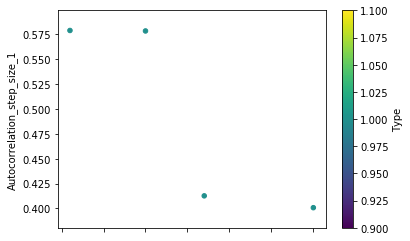

In [81]:
ax2 = DF.plot.scatter(x='Number_Maxima',
                      y='Autocorrelation_step_size_1',
                      c='Type',
                      colormap='viridis')

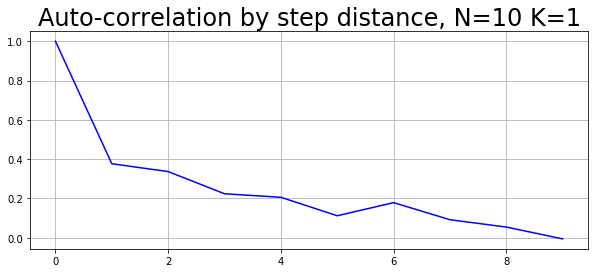

Max Fitness				 1.0
Min Fitness				 0.0
Normed difference in fitness		 4.66598714426424
Distance btw min and max		 10
Avg distance for 90th percentile to Max	 2.8058252427184467
Num of Local Maxima			 54


In [25]:
Get_Landscape_Statistics(current_land,N,K)


In [20]:
Current_Maximas_Model = Local_Maxima_Locations(current_land)
Num_Maxima = sum(Current_Maximas_Model['Maxima'])
#Maxima_counts.append(Num_Maxima)

In [21]:
Num_Maxima

54

In [88]:
Current_Maximas_Model[Current_Maximas_Model['Maxima']==1]

,Fitness,Location,Maxima
0000110110,0.680767,"(0, 0, 0, 0, 1, 1, 0, 1, 1, 0)",1
0000111011,0.752920,"(0, 0, 0, 0, 1, 1, 1, 0, 1, 1)",1
0001011100,0.694638,"(0, 0, 0, 1, 0, 1, 1, 1, 0, 0)",1
0001011111,0.779020,"(0, 0, 0, 1, 0, 1, 1, 1, 1, 1)",1
0001100011,0.749934,"(0, 0, 0, 1, 1, 0, 0, 0, 1, 1)",1
0001100110,0.627641,"(0, 0, 0, 1, 1, 0, 0, 1, 1, 0)",1
0001101010,0.569198,"(0, 0, 0, 1, 1, 0, 1, 0, 1, 0)",1
0001110001,0.754191,"(0, 0, 0, 1, 1, 1, 0, 0, 0, 1)",1
0010001110,0.682561,"(0, 0, 1, 0, 0, 0, 1, 1, 1, 0)",1
0010101010,0.721182,"(0, 0, 1, 0, 1, 0, 1, 0, 1, 0)",1
